## KILIAN KEMGNE
## ENSPY
## 5GI

### Importation des bibliothèques

In [245]:
conda install -c anaconda py-xgboost

Solving environment: ...working... done


Note: you may need to restart the kernel to use updated packages.## Package Plan ##




==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.10.0





  environment location: C:\Users\Kilian\anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          12 KB  anaconda
    libxgboost-1.7.3           |       hd77b12b_0         2.6 MB  anaconda
    py-xgboost-1.7.3           |   py39haa95532_0         196 KB  anaconda
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  anaconda/win-64::_py-xgboost-mutex-2.0-cpu_0
  libxgboost         anaconda/win-64::libxgboost-1.7.3-hd77b12b_0
  py-xgboost         anaconda/win-64::py-xgboost-1.7.3-py39haa95532_0




py-xgboost-1.7.3     | 196 KB    |            |   0% 
py-xgboost-1.7.3     | 196 KB    | 8          |   8% 
py-xgboost-1.7.3     | 196 KB    | #6     

Please update conda by running

    $ conda update -n base -c defaults conda




In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import xgboost as xgb

### Pré traitement des données

> Problèmes rencontrés : Certaines lignes du dataset sont mal séparées et les données se retrouve décalées par rapport à leur colonne d'origine et, d'autres lignes contiennent des elements qui n'ont pas de sens par rapport au données de la colonne en question (contenant le caractère : N,""0")

> Proposition de solution : En analysant les données, on se rend compte que certaines lignes se termine par 0, 1, 2 ou 3 virgules tandisqu'elles devaient se terminer par 4. Et on se rend compte qu'il y a des virgules superflues ajouter à l'intérieur de la ligne. Ainsi, nous avons commencé par supprimer ces virgules afin de bien structurer le dataset. Pour le second problème, nous nous proposons de supprimer toutes les lignes affectées.

In [170]:
def preprocess_csv(input_file, output_file):
    with open(input_file, 'r', newline='') as infile, open(output_file, 'w', newline='') as outfile:
        for line in infile:
            # Supprimer les espaces en début et fin de ligne
            line = line.strip()

            # On ignore pour le fichier à jour les lignes contenant ce caractère
            if 'N,""0"' in line :
                continue
                
            if line.endswith(',,,') and not line.endswith(',,,,'):
                # Trouver la position de la deuxième virgule à partir du début
                second_comma_index = line.find(',', line.find(',') + 1)

                # Supprimer la deuxième virgule de la ligne
                line = line[:second_comma_index] + line[second_comma_index + 1:]

            elif line.endswith(',,') and not line.endswith(',,,') and not line.endswith(',,,,'):
                for i in range(2) :
                    # Trouver la position de la deuxième virgule à partir du début
                    second_comma_index = line.find(',', line.find(',') + 1)

                    # Supprimer la deuxième virgule de la ligne
                    line = line[:second_comma_index] + line[second_comma_index + 1:]

            # Vérifier si la ligne se termine par exactement trois virgules
            elif line.endswith(',') and not line.endswith(',,') and not line.endswith(',,,') and not line.endswith(',,,,'):
                for i in range(3) :
                    # Trouver la position de la deuxième virgule à partir du début
                    second_comma_index = line.find(',', line.find(',') + 1)

                    # Supprimer la deuxième virgule de la ligne
                    line = line[:second_comma_index] + line[second_comma_index + 1:]

            elif not line.endswith(',') and not line.endswith(',,') and not line.endswith(',,,') and not line.endswith(',,,,'):
                for i in range(4) :
                    # Trouver la position de la deuxième virgule à partir du début
                    second_comma_index = line.find(',', line.find(',') + 1)

                    # Supprimer la deuxième virgule de la ligne
                    line = line[:second_comma_index] + line[second_comma_index + 1:]

            # Suppression des virgules superflues en fin de ligne
            line = line.rstrip(',')
            # Écrire la ligne résultante dans le fichier de sortie
            outfile.write(line + '\n')

# Utilisation du code
input_filename = 'ks_dataset.csv'
output_filename = 'ks_dataset_update.csv'

preprocess_csv(input_filename, output_filename)
print("Successfully terminated")

Successfully terminated


In [274]:
#Imporation du nouveau dataset
df = pd.read_csv('ks_dataset_update.csv', encoding='latin-1')

In [275]:
# Visualisation de quelques données
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319953 entries, 0 to 319952
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              319953 non-null  int64  
 1   name            319949 non-null  object 
 2   category        319953 non-null  object 
 3   main_category   319953 non-null  object 
 4   currency        319953 non-null  object 
 5   deadline        319953 non-null  object 
 6   goal            319953 non-null  float64
 7   launched        319953 non-null  object 
 8   pledged         319953 non-null  float64
 9   state           319953 non-null  object 
 10  backers         319953 non-null  int64  
 11  country         319953 non-null  object 
 12  usd pledged     319953 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 31.7+ MB


In [276]:
# On verifie si les lignes contienent bien des element homogènes (de même nature afin de s'assure que les lignes ne soient plus décalées)
df['currency '].unique()

array(['GBP', 'USD', 'CAD', 'NOK', 'AUD', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD'], dtype=object)

In [223]:
# Affichage des lignes où la colonne "name" a une valeur nulle
null_name_rows = df[df['name '].isnull()]

# Affichage du résultat
print(null_name_rows)

               ID  name        category  main_category  currency   \
141170  1848699072   NaN  Narrative Film   Film & Video       USD   
259822   634871725   NaN     Video Games          Games       GBP   
262141   648853978   NaN  Product Design         Design       USD   
286464   796533179   NaN        Painting            Art       USD   

                  deadline      goal             launched   pledged   \
141170  2012-02-29 15:04:00  200000.0  2012-01-01 12:35:31     100.0   
259822  2013-01-06 23:00:00    2000.0  2012-12-19 23:57:48     196.0   
262141  2016-07-18 05:01:47    2500.0  2016-06-18 05:01:47       0.0   
286464  2011-12-05 05:59:00   35000.0  2011-11-06 23:55:55     220.0   

           state   backers  country   usd pledged   
141170     failed         1       US    100.000000  
259822     failed        12       GB    317.728436  
262141  suspended         0       US      0.000000  
286464     failed         5       US    220.000000  


In [176]:
df.dropna(subset=['name '], inplace=True)

In [224]:
df['state '].unique()

array(['failed', 'canceled', 'successful', 'live', 'suspended'],
      dtype=object)

In [225]:
df['country '].unique()

array(['GB', 'US', 'CA', 'NO', 'AU', 'IT', 'DE', 'IE', 'ES', 'MX', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'LU', 'SG'],
      dtype=object)

In [179]:
# On s'assure de la coherence entre la date de début et la fin. 
df['launched '] = pd.to_datetime(df['launched '])
df['deadline '] = pd.to_datetime(df['deadline '])

df_test = df[df['launched '] > df['deadline ']]

df_test

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged


> Problème rencontré : On constate que pour certains projets se trouvant dans une localité où en US et utilisant comme monnaie le USD, la conversion du prix en monnaie locale (pledged) et du prix en usd (usd pledged) sont différents. Ce qui n'est pas normal vu que la monnaie locale est le USD et les deux colonnes devraient être identiques

> Solution apportée : On a jugé necessaire de supprimer les dites lignes. Nous avons d'abord voulu reconduire les valeurs de pledged dans usd pledged pour ce cas spécifique mais, ce serait modifier les données ce qui n'est pas bien

In [180]:
# On vérifie la coherence de la conversion des prix en USD
df_filtre = df.loc[(df['pledged '] != df['usd pledged '] ) & (df['currency '] == 'USD')]

# Afficher le DataFrame résultant
df_filtre

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
27,1000117861,Ledr workbook: one tough journal!,Product Design,Design,USD,2016-10-08 02:00:00,1000.0,2016-09-07 13:14:26,47266.0,successful,549,US,11253.0
62,1000261018,Diposta - liberating people from their postal ...,Web,Technology,USD,2016-08-23 13:18:36,100000.0,2016-07-24 13:18:36,141.0,failed,3,US,100.0
92,1000415969,Disaster Area: A Podcast,Radio & Podcasts,Publishing,USD,2016-12-28 17:58:04,1000.0,2016-11-28 17:58:04,125.0,live,3,US,0.0
93,1000422671,Titanium EDC Bottle Opener,Product Design,Design,USD,2016-11-20 16:23:31,500.0,2016-10-21 16:23:31,156.0,failed,4,US,1.0
103,1000481607,Alpha Omega E.P.,Metal,Music,USD,2016-09-30 22:34:26,1000.0,2016-09-05 22:34:26,472.0,failed,13,US,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319813,999120006,In The Ring,Shorts,Film & Video,USD,2016-12-01 19:15:04,12000.0,2016-11-01 18:15:04,12206.0,successful,152,US,3676.0
319815,999133026,Kuña: documental sobre la mujer paraguaya,Documentary,Film & Video,USD,2016-08-14 00:29:00,10000.0,2016-07-13 01:58:44,10588.0,successful,181,US,350.0
319834,999270657,"Cotopaxi ConnectCustom Gear, Co-Designed",Product Design,Design,USD,2017-01-19 08:00:35,25000.0,2016-11-20 08:00:35,5763.0,live,108,US,1505.0
319885,999587299,Arcane Sally & Mr. Steam #2,Comic Books,Comics,USD,2016-09-19 08:59:00,1500.0,2016-08-26 01:09:58,6771.0,successful,285,US,1617.0


In [277]:
# Retrait des lignes correspondantes
df.drop(df[(df['pledged '] != df['usd pledged ']) & (df['currency '] == 'USD')].index, inplace=True)

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305154 entries, 0 to 319952
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              305154 non-null  int64  
 1   name            305150 non-null  object 
 2   category        305154 non-null  object 
 3   main_category   305154 non-null  object 
 4   currency        305154 non-null  object 
 5   deadline        305154 non-null  object 
 6   goal            305154 non-null  float64
 7   launched        305154 non-null  object 
 8   pledged         305154 non-null  float64
 9   state           305154 non-null  object 
 10  backers         305154 non-null  int64  
 11  country         305154 non-null  object 
 12  usd pledged     305154 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 32.6+ MB


### Identification des insights pertinents liés au succes ou à l'echec de la campagne

> La catégorie

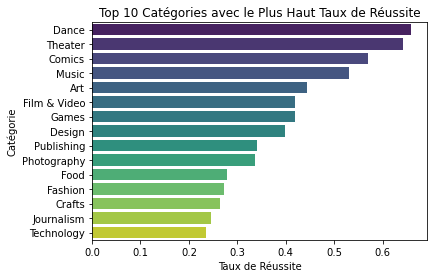

In [230]:
# Taux de réussite par catégorie
success_by_category = df.groupby('main_category ')['state '].value_counts(normalize=True).unstack().fillna(0)
success_by_category['success_rate'] = success_by_category['successful'] / (success_by_category['successful'] + success_by_category['failed'])

# Top 10 catégories avec le plus haut taux de réussite
top_categories = success_by_category.sort_values(by='success_rate', ascending=False).head(20)
sns.barplot(x=top_categories['success_rate'], y=top_categories.index, palette='viridis')
plt.title('Top 10 Catégories avec le Plus Haut Taux de Réussite')
plt.xlabel('Taux de Réussite')
plt.ylabel('Catégorie')
plt.show()


> Par année de lancement en se basant sur la deadline et launched

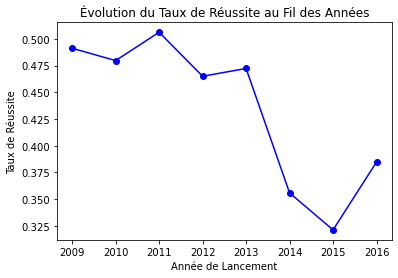

In [231]:
# Convertir les colonnes de dates en type datetime
df['deadline '] = pd.to_datetime(df['deadline '])
df['launched '] = pd.to_datetime(df['launched '])

# Créer une nouvelle colonne pour l'année de lancement
df['launch_year'] = df['launched '].dt.year

# Taux de réussite par année
success_by_year = df.groupby('launch_year')['state '].value_counts(normalize=True).unstack().fillna(0)
success_by_year['success_rate'] = success_by_year['successful'] / (success_by_year['successful'] + success_by_year['failed'])

# Tracer le taux de réussite au fil des années
plt.plot(success_by_year.index, success_by_year['success_rate'], marker='o', linestyle='-', color='b')
plt.title('Évolution du Taux de Réussite au Fil des Années')
plt.xlabel('Année de Lancement')
plt.ylabel('Taux de Réussite')
plt.show()

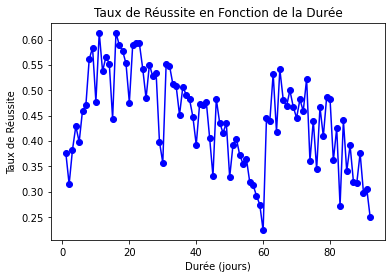

In [279]:
# Convertir les colonnes de dates en type datetime
df['deadline '] = pd.to_datetime(df['deadline '])
df['launched '] = pd.to_datetime(df['launched '])

# Calculer la différence de date entre 'deadline' et 'launched'
df['duration'] = (df['deadline '] - df['launched ']).dt.days

# Tracer le succès en fonction de la durée
success_by_duration = df.groupby('duration')['state '].value_counts(normalize=True).unstack().fillna(0)
success_by_duration['success_rate'] = success_by_duration['successful'] / (success_by_duration['successful'] + success_by_duration['failed'])

# Tracer le taux de réussite en fonction de la durée
plt.plot(success_by_duration.index, success_by_duration['success_rate'], marker='o', linestyle='-', color='b')
plt.title('Taux de Réussite en Fonction de la Durée')
plt.xlabel('Durée (jours)')
plt.ylabel('Taux de Réussite')
plt.show()


On constate que pour les projets ayant débutés entre les années 2009 et 2013 ont eu un taux de reussite par rapport à ceux ayant echoués (failed) de plus de 45%

> En comparant le coût effectif du projet (pledged) par rapport au montant demandé (goal)

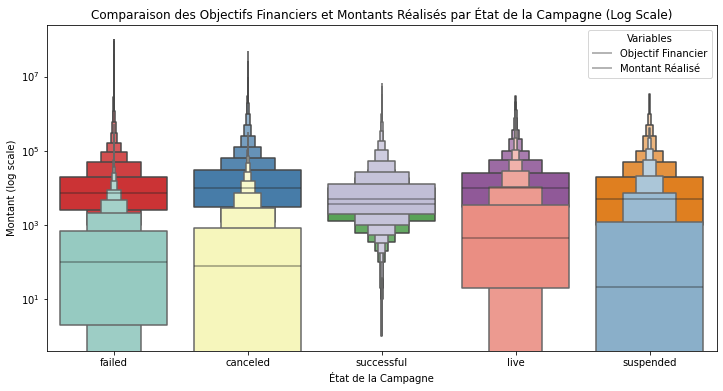

In [232]:
# Tracer un boxplot pour comparer 'goal' et 'pledged' en fonction de l'état de la campagne
plt.figure(figsize=(12, 6))
sns.boxenplot(x='state ', y='goal ', data=df, showfliers=False, palette='Set1')
sns.boxenplot(x='state ', y='pledged ', data=df, showfliers=False, palette='Set3')
plt.yscale('log')
plt.title("Comparaison des Objectifs Financiers et Montants Réalisés par État de la Campagne (Log Scale)")
plt.xlabel("État de la Campagne")
plt.ylabel("Montant (log scale)")
plt.legend(title='Variables', labels=['Objectif Financier', 'Montant Réalisé'])
plt.show()


On constate que pour les projets ayant réussit, l'objectif financier etait assez proche du montant demandé 

### Entrainement et test

In [298]:
# Suppression des colonnes non nécessaires
df_preprocessed = df.drop(['ID ', 'name ', 'currency ', 'deadline ', 'launched ', 'country ', 'backers ', 'category '], axis=1)

# df_preprocessed['goal_binary'] = df['goal '].apply(lambda x: 0 if x < 6000 else 1)

# Gestion des valeurs manquantes
df_preprocessed = df_preprocessed.dropna()

# Encodage de la variable cible 'state'
le = LabelEncoder()
df_preprocessed['state '] = le.fit_transform(df_preprocessed['state '])

# Conversion des variables catégorielles en variables indicatrices
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['main_category '], drop_first=True)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed.drop('state ', axis=1), df_preprocessed['state '], test_size=0.2, random_state=50)

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [299]:
# Convertir les données en format DMatrix pour XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Définir les paramètres du modèle
params = {
    'objective': 'multi:softmax',  # classification multiclasse
    'num_class': 5,  # nombre de classes dans la variable cible
    'eval_metric': 'mlogloss',  # mesure de performance
    'eta': 0.1,  # taux d'apprentissage
    'max_depth': 10,  # profondeur maximale de l'arbre
    'subsample': 0.8,  # proportion des échantillons utilisés pour l'entraînement de chaque arbre
    'colsample_bytree': 0.8,  # proportion de variables utilisées pour l'entraînement de chaque arbre
    'seed': 20 # graine pour la reproductibilité
}

# Diviser les données en ensembles d'entraînement et de validation
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Entraîner le modèle XGBoost avec la possibilité d'évaluer les performances sur l'ensemble de validation
num_round = 100
xgb_model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=True)

# Prédire sur l'ensemble de test
y_pred = xgb_model.predict(dtest)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost accuracy is: {:.4f}".format(accuracy))


[0]	train-mlogloss:1.42507	eval-mlogloss:1.42618
[1]	train-mlogloss:1.29714	eval-mlogloss:1.29904
[2]	train-mlogloss:1.17616	eval-mlogloss:1.17886
[3]	train-mlogloss:1.08738	eval-mlogloss:1.09077
[4]	train-mlogloss:1.00122	eval-mlogloss:1.00547
[5]	train-mlogloss:0.94548	eval-mlogloss:0.95058
[6]	train-mlogloss:0.87785	eval-mlogloss:0.88368
[7]	train-mlogloss:0.82728	eval-mlogloss:0.83390
[8]	train-mlogloss:0.78258	eval-mlogloss:0.79003
[9]	train-mlogloss:0.73596	eval-mlogloss:0.74392
[10]	train-mlogloss:0.70172	eval-mlogloss:0.71038
[11]	train-mlogloss:0.66380	eval-mlogloss:0.67309
[12]	train-mlogloss:0.62994	eval-mlogloss:0.63994
[13]	train-mlogloss:0.60494	eval-mlogloss:0.61558
[14]	train-mlogloss:0.57812	eval-mlogloss:0.58926
[15]	train-mlogloss:0.55803	eval-mlogloss:0.56991
[16]	train-mlogloss:0.53954	eval-mlogloss:0.55213
[17]	train-mlogloss:0.52672	eval-mlogloss:0.53972
[18]	train-mlogloss:0.50748	eval-mlogloss:0.52115
[19]	train-mlogloss:0.49014	eval-mlogloss:0.50450
[20]	train

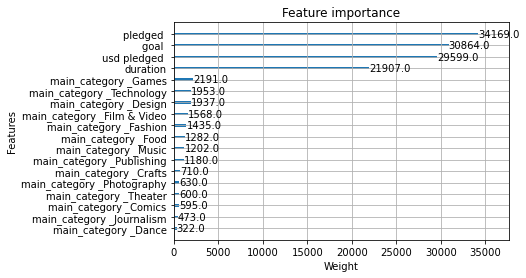

In [301]:
# Tracer l'importance des variables
xgb.plot_importance(xgb_model, importance_type='weight', xlabel='Weight', ylabel='Features')
plt.show()